<a href="https://colab.research.google.com/github/The-cheater/Deep_Learning_Models/blob/main/gaf_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyts matplotlib pandas


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/datasets/gait-in-neurodegenerative-disease-database-1.0.0.zip'
extract_path = '/content/gait_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to:", extract_path)


✅ Extracted to: /content/gait_dataset


In [ ]:
# Full path to the subfolder where .ts files are
ts_dir = '/content/gait_dataset/gait-in-neurodegenerative-disease-database-1.0.0'

columns = [
    "Elapsed Time", "Left Stride", "Right Stride",
    "Left Swing", "Right Swing", "Left Swing %",
    "Right Swing %", "Left Stance", "Right Stance",
    "Left Stance %", "Right Stance %",
    "Double Support", "Double Support %"
]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyts.image import MarkovTransitionField
import numpy as np

def analyze_subject(subject_filename):
    # Construct full path
    ts_file = os.path.join(ts_dir, subject_filename)

    if not os.path.isfile(ts_file):
        print(f"❌ File not found: {ts_file}")
        return

    print(f"📄 Analyzing file: {ts_file}")

    # Load time series data
    df = pd.read_csv(ts_file, sep='\s+', names=columns)

    # Plot Time Series (Left Stride Interval)
    plt.figure(figsize=(10, 4))
    plt.plot(df["Elapsed Time"], df["Left Stride"], label="Left Stride Interval")
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("Stride Interval (s)")
    plt.title(f"Left Stride Interval - {subject_filename}")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Generate MTF Image
    stride_data = df["Left Stride"].dropna().values[:100]
    if len(stride_data) < 2:
        print("⚠️ Not enough data for MTF image.")
        return

    X = stride_data.reshape(1, -1)
    mtf = MarkovTransitionField(n_bins=8, strategy='quantile')
    X_mtf = mtf.fit_transform(X)

    # Plot MTF
    plt.figure(figsize=(5, 5))
    plt.imshow(X_mtf[0], cmap='rainbow', origin='lower')
    plt.title(f"MTF Image - {subject_filename}")
    plt.colorbar()
    plt.show()


📄 Analyzing file: /content/gait_dataset/gait-in-neurodegenerative-disease-database-1.0.0/control6.ts


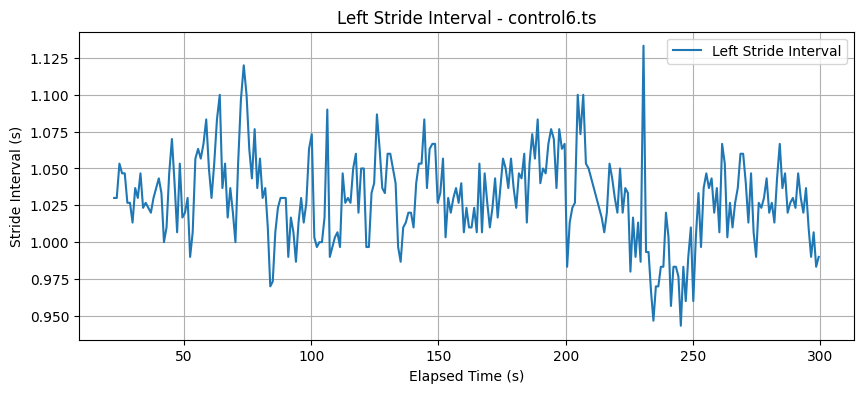

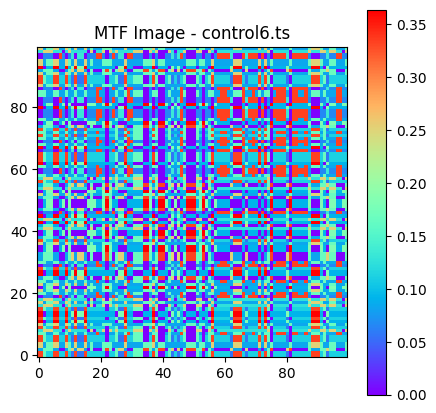

In [ ]:
analyze_subject('control6.ts')  # ✅ Make sure filename matches exactly


<ipython-input-21-39a28ffe87c4>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ts_path, delim_whitespace=True, header=None)


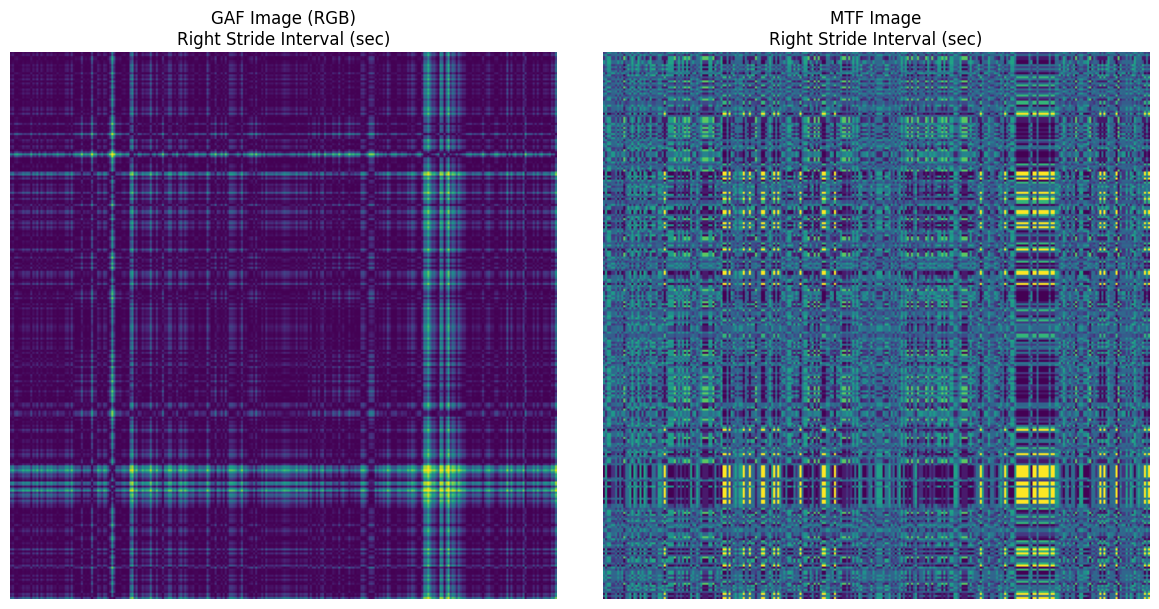

In [21]:
# Install pyts if not already installed
!pip install -q pyts

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pyts.image import GramianAngularField, MarkovTransitionField
from matplotlib.cm import viridis

# === CONFIGURATION ===
zip_path = '/content/drive/MyDrive/datasets/gait-in-neurodegenerative-disease-database-1.0.0.zip'
extract_path = '/content/gait_dataset'
subject_id = 'control6'  # e.g., 'hunt2', 'als4', 'control3'
feature_name = 'Right Stride Interval (sec)'  # Human-readable name

# === FEATURE NAME TO COLUMN MAPPING ===
feature_columns = {
    'Elapsed Time (sec)': 0,
    'Left Stride Interval (sec)': 1,
    'Right Stride Interval (sec)': 2,
    'Left Swing Interval (sec)': 3,
    'Right Swing Interval (sec)': 4,
    'Left Swing Interval (% of stride)': 5,
    'Right Swing Interval (% of stride)': 6,
    'Left Stance Interval (sec)': 7,
    'Right Stance Interval (sec)': 8,
    'Left Stance Interval (% of stride)': 9,
    'Right Stance Interval (% of stride)': 10,
    'Double Support Interval (sec)': 11,
    'Double Support Interval (% of stride)': 12
}

# === EXTRACT ZIP IF NOT ALREADY DONE ===
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# === LOAD .ts FILE ===
ts_path = os.path.join(extract_path, f'gait-in-neurodegenerative-disease-database-1.0.0/{subject_id}.ts')
df = pd.read_csv(ts_path, delim_whitespace=True, header=None)

# === GET FEATURE SERIES ===
if feature_name not in feature_columns:
    raise ValueError(f"Invalid feature name: {feature_name}")

feature_index = feature_columns[feature_name]
ts = df.iloc[:, feature_index].values

# === GAF: SCALE TO [-1, 1] ===
ts_gaf_scaled = 2 * (ts - np.min(ts)) / (np.max(ts) - np.min(ts)) - 1
ts_gaf_scaled = ts_gaf_scaled.reshape(1, -1)

gaf = GramianAngularField(image_size=ts_gaf_scaled.shape[1], method='summation')
gaf_image = gaf.fit_transform(ts_gaf_scaled)[0]

# Convert to RGB using matplotlib colormap
gaf_rgb = viridis((gaf_image - np.min(gaf_image)) / (np.max(gaf_image) - np.min(gaf_image)))[:, :, :3]

# === MTF: NORMALIZE TO [0, 1] USING QUANTILE STRATEGY ===
scaler = MinMaxScaler()
ts_mtf_scaled = scaler.fit_transform(ts.reshape(-1, 1)).reshape(1, -1)

mtf = MarkovTransitionField(image_size=ts_mtf_scaled.shape[1], n_bins=8, strategy='quantile')
mtf_image = mtf.fit_transform(ts_mtf_scaled)[0]

# === PLOT SIDE BY SIDE ===
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(gaf_rgb)
axes[0].set_title(f'GAF Image (RGB)\n{feature_name}')
axes[0].axis('off')

axes[1].imshow(mtf_image, cmap='viridis')
axes[1].set_title(f'MTF Image\n{feature_name}')
axes[1].axis('off')

plt.tight_layout()
plt.show()
